# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [ ]:
# Note, this example concentrate on implementing the mechanics of the training process of GAN system
# we use the most simple neural model - dense linear layers

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'vanilla-GAN-batch_32'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
# generate a sample of fake images by sampling the noise
def get_sample_image(G, n_noise):
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

## Models

- vanilla GAN- simplest possible fully connected model

no convolutional layers and more complex stuff

- DC GAN - Deep Convolutional GAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
n_noise = 100

## Sending to CUDA

if available

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

## Transforming and loading dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
# batch_size = 64
# batch_size = 128
batch_size = 32

In [ ]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

## Optimization function

BCE Loss - Binary Crossentropy

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) # lr normalnie jest ok 10^-6
#D_opt = torch.optim.Adam(D.parameters(), lr=0.000002, betas=(0.5, 0.999)) # SUPER SUPER BAD NOOOISE
#D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999)) # Quite good
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999)) # kinda good ish some noise but u can tell the numbers


## Deiscriminator and Generator params:
- epochs
- step
- n_critic - how many epochs of Discriminator should happen for one epoch of generator

In [ ]:
# max_epoch = 20 # you should train at least for 10 - 15 epochs
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

# max_epoch = 1 # you should train at least for 10 - 15 epochs ---- Kinda Generator lost performance
# step = 0
# n_critic = 2 # for training more k steps about Discriminator

# max_epoch = 5 # you should train at least for 10 - 15 epochs ---- Noice was removed from background but stil not so good
# step = 0
# n_critic = 5 # for training more k steps about Discriminator

# max_epoch = 5 # you should train at least for 10 - 15 epochs ---- Better than prevous one - no revelation though
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

# max_epoch = 25 # you should train at least for 10 - 15 epochs ---- Much metter but still noice
# step = 0
# n_critic = 1 # for training more k steps about Discriminator

max_epoch = 15 # you should train at least for 10 - 15 epochs ----
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [ ]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/15, Step: 0, D Loss: 1.3233416080474854, G Loss: 0.724291205406189
Epoch: 0/15, Step: 500, D Loss: 1.467101812362671, G Loss: 0.41705626249313354
Epoch: 0/15, Step: 1000, D Loss: 1.296416997909546, G Loss: 0.901698112487793
Epoch: 0/15, Step: 1500, D Loss: 1.198051929473877, G Loss: 1.0045291185379028
Epoch: 1/15, Step: 2000, D Loss: 1.2098982334136963, G Loss: 1.1103514432907104
Epoch: 1/15, Step: 2500, D Loss: 1.1240220069885254, G Loss: 1.0078368186950684
Epoch: 1/15, Step: 3000, D Loss: 1.4588420391082764, G Loss: 1.68808913230896
Epoch: 1/15, Step: 3500, D Loss: 1.203018307685852, G Loss: 0.8395799398422241
Epoch: 2/15, Step: 4000, D Loss: 1.1922842264175415, G Loss: 0.7601680159568787
Epoch: 2/15, Step: 4500, D Loss: 1.1461682319641113, G Loss: 1.0377280712127686
Epoch: 2/15, Step: 5000, D Loss: 1.0877245664596558, G Loss: 0.9896990656852722
Epoch: 2/15, Step: 5500, D Loss: 1.2140871286392212, G Loss: 1.073652982711792
Epoch: 3/15, Step: 6000, D Loss: 1.2484054565429688,

## Visualize Sample

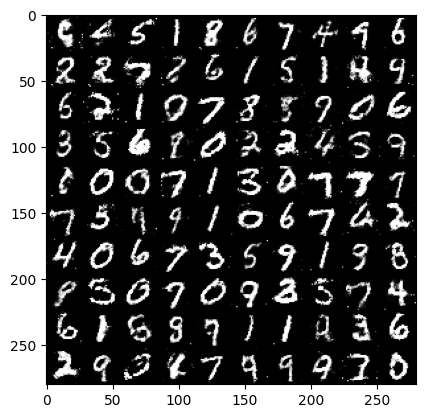

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')